# Build Model

### Import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def wrangle(file_path):
    df = pd.read_csv(file_path)
    # drop columns which are not useful in the model
    df = df.drop(columns=['year', 'uniqueid'])
    
    """ Encoding Categorical Features """
    # Identify columns with categorical values for encoding
    categorical_columns = [x for x in df.columns if type(df[x][1]) == str]
    print(categorical_columns)
    print(f"Our dataframe has {len(categorical_columns)} categorical columns")

    # Instantiate label encoder
    label_encoder = LabelEncoder()

    # Transform data
    for column in df.columns:
      df[column] = label_encoder.fit_transform(df[column])

    return df

In [ ]:
# data = wrangle("Train.csv")
data = wrangle("/content/drive/MyDrive/Financial Inclusion in Africa/Train.csv")
print(data.info())
print(f"DataFrame Shape: {data.shape}")
data.head()

['country', 'bank_account', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']
Our dataframe has 9 categorical columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   country                 23524 non-null  int64
 1   bank_account            23524 non-null  int64
 2   location_type           23524 non-null  int64
 3   cellphone_access        23524 non-null  int64
 4   household_size          23524 non-null  int64
 5   age_of_respondent       23524 non-null  int64
 6   gender_of_respondent    23524 non-null  int64
 7   relationship_with_head  23524 non-null  int64
 8   marital_status          23524 non-null  int64
 9   education_level         23524 non-null  int64
 10  job_type                23524 non-null  int64
dtypes: int64(11)
memory

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,1,0,1,2,8,0,5,2,3,9
1,0,0,0,0,4,54,0,1,4,0,4
2,0,1,1,1,4,10,1,3,3,5,9
3,0,0,0,1,4,18,0,1,2,2,3
4,0,0,1,0,7,10,1,0,3,2,5


## Split
Feature matrix and Target Vector


In [ ]:
target = "bank_account"
X= data.drop(columns=target)
y = data[target]
print(X.shape)
print(y.shape)

(23524, 10)
(23524,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18819, 10)
y_train shape: (18819,)
X_test shape: (4705, 10)
y_test shape: (4705,)


## Resample Data
We will use **Oversampling** since we had an imbalanced class of target vector

In [ ]:
# Instantiate RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)

X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)

(32298, 10)


## Build Model

### Baseline

In [ ]:
baseline_accuracy = y_train.value_counts(normalize=True).max()
baseline_accuracy

0.858122110632871

### Iterate

In [ ]:
# Instantiate "classifier" as "clf"
clf = RandomForestClassifier(random_state=42)

# Perform cross-validation with your classifier, using the over-sampled training data.
# We want five folds, so set cv to 5.
# We also want to speed up training, to set n_jobs to -1
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

# The above step is not important

[0.93173375 0.93405573 0.9371517  0.9304846  0.931878  ]


In [ ]:
# Instantiate "classifier" as "clf" (could be a pipeline)
clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42)
    )

# Define a hyperparameter grid for model tuning
params = {
    "randomforestclassifier__n_estimators": range(25, 100, 10),
    "randomforestclassifier__max_depth": range(5, 30, 5)
}
params

{'randomforestclassifier__n_estimators': range(25, 100, 10),
 'randomforestclassifier__max_depth': range(5, 30, 5)}

Perform a hyperparameter grid search

In [ ]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 30, 5),
                         'randomforestclassifier__n_estimators': range(25, 100, 10)},
             verbose=1)

In [ ]:
import time

# Start time
start_time = time.time()

# Train Model
model.fit(X_train, y_train)

# stop-time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Model Training Time: {int(elapsed_time // 60)} minutes and {int(elapsed_time % 60)} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Model Training Time: 2 minutes and 58 seconds


In [ ]:
# get cross-validation (cv) results from the model
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,1.626467,0.151944,0.118854,0.051051,10,95,"{'randomforestclassifier__max_depth': 10, 'ran...",0.886026,0.886026,0.890011,0.875930,0.886261,0.884850,0.004711,1
14,1.461960,0.184380,0.074791,0.002395,10,85,"{'randomforestclassifier__max_depth': 10, 'ran...",0.885760,0.885760,0.889479,0.875399,0.886792,0.884638,0.004816,2
13,2.142129,0.835494,0.123079,0.063278,10,75,"{'randomforestclassifier__max_depth': 10, 'ran...",0.886291,0.884697,0.889745,0.875399,0.886261,0.884479,0.004831,3
9,1.543273,0.355309,0.097171,0.049519,10,35,"{'randomforestclassifier__max_depth': 10, 'ran...",0.884166,0.886291,0.889214,0.876196,0.885198,0.884213,0.004349,4
10,1.056132,0.049848,0.106561,0.047969,10,45,"{'randomforestclassifier__max_depth': 10, 'ran...",0.883634,0.884166,0.890808,0.875930,0.886261,0.884160,0.004829,5


In [ ]:
# pull the best model hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 95}

### Evaluate

#### Accuracy Score

In [ ]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", round(train_accuracy, 4))
print(f"Test Accuracy: {round(test_accuracy, 4)} vs Baseline Accuracy: {baseline_accuracy}")

Training Accuracy: 0.9038
Test Accuracy: 0.8912 vs Baseline Accuracy: 0.858122110632871


**Our model performed better than Logistic Regression**

Next we are going to look at how the model actually performed by looking at the numbers

In [ ]:
# calculate how many values belong to the positive and negative classes
y_test.value_counts()

0    4063
1     642
Name: bank_account, dtype: int64

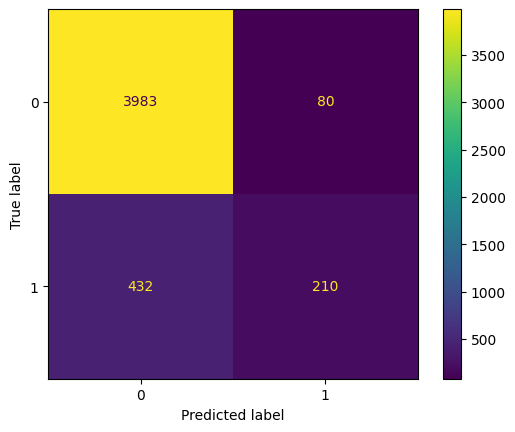

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

Despite having a better accuracy score than the baseline, the Confusion Matrix shows how the model fails to classify the targets correctly. This could be missleading. If 85% of individuals in our dataset do not have a bank account, all the model has to do is to always predict ["bank_account": False] and it will be right 89% of the time. The accuracy score will be right, **but will not tell us what we need with accuracy.**

#### Precision / Recall
Instead, we can evaluate our model using **precision and recall**. The precision score is important when we want our model to only predict that an individual owns a bank account if its very confident in its prediction. The recall score is important if we want to make sure to identify all individuals who have have a bank account, even if that means being incorrect sometimes.

In this case, we are more interested with individuals who do not own a bank account.

In [ ]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4063
           1       0.72      0.33      0.45       642

    accuracy                           0.89      4705
   macro avg       0.81      0.65      0.70      4705
weighted avg       0.88      0.89      0.87      4705



•	Precision:
> For the majority class (0), the precision is 0.90, indicating that out of all instances predicted as having no bank account, 90% are actually true negatives.

>For the minority class (1), the precision is 0.72, indicating that out of all instances predicted as having a bank account, 72% are actually true positives.

•	Recall:
>For the majority class (0), the recall is 0.98, indicating that the model correctly identifies 98% of the instances with no bank account out of all actual instances with no bank account.

>For the minority class (1), the recall is 0.33, indicating that the model only captures 33% of the instances with a bank account out of all actual instances with a bank account.

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

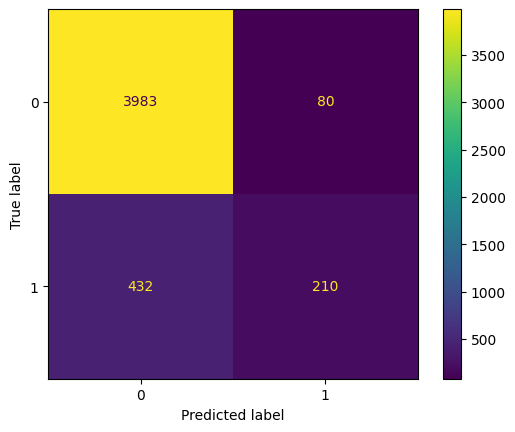

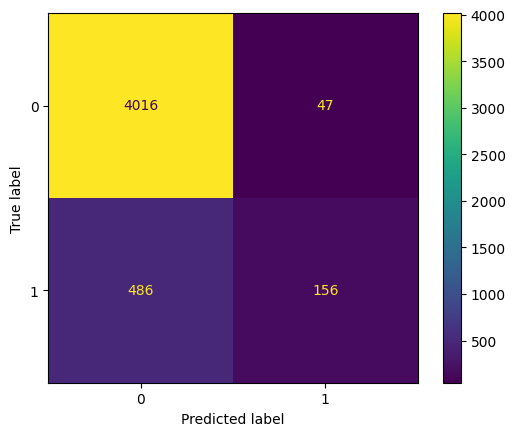

In [ ]:
def make_confusion_matrix(threshold):

  y_pred_proba = model.predict_proba(X_test)[:, -1]
  y_pred = y_pred_proba > threshold
  #conf_matrix = confusion_matrix(y_test, y_pred)
  #tn, fp, fn, tp = conf_matrix.ravel()
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)

widgets.interact(make_confusion_matrix, threshold=thresh_widget);

This interactive visualization helps you understand how changing the threshold affects the performance of your model. You can observe how the counts in the confusion matrix change as you adjust the threshold, allowing you to analyze the trade-off between false positives and false negatives.

## Results Communication

In [ ]:
# Get feature names
features = model.feature_names_in_
features

array(['country', 'location_type', 'cellphone_access', 'household_size',
       'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'], dtype=object)

In [ ]:
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
importances

array([0.09273219, 0.04882294, 0.07440146, 0.06315957, 0.13918422,
       0.02936933, 0.03877333, 0.03398081, 0.31855627, 0.16101987])

In [ ]:
# Series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

gender_of_respondent      0.029369
marital_status            0.033981
relationship_with_head    0.038773
location_type             0.048823
household_size            0.063160
cellphone_access          0.074401
country                   0.092732
age_of_respondent         0.139184
job_type                  0.161020
education_level           0.318556
dtype: float64

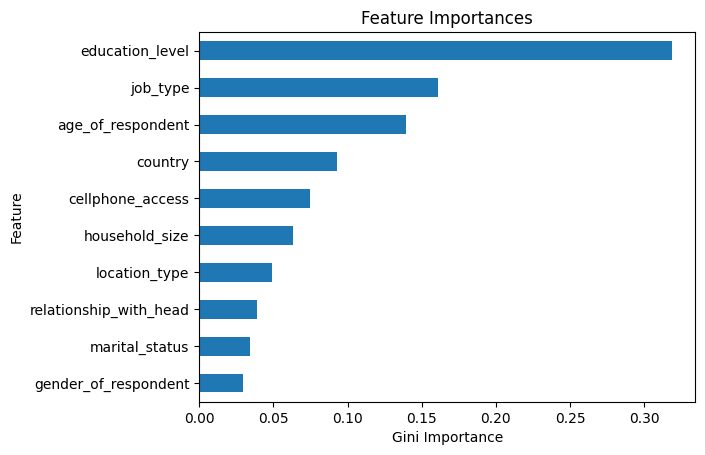

In [ ]:
# Plot important features
feat_imp.plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importances");

The feature importances highlight the significance of different features in predicting the likelihood of financial inclusion. This information is crucial for stakeholders seeking to understand the driving factors behind financial inclusion and make informed decisions. Here is a brief explanation of the 3 most significant feature importances:
>1.	**Education Level**: The education level of individuals has the highest importance in predicting financial inclusion. This suggests that higher education may positively influence an individual's likelihood of having a bank account.
>2.	**Job Type**: The type of job held by individuals is the second most important factor. Certain job types may offer more financial stability or access to banking services, leading to higher rates of financial inclusion.
>3.	**Age of Respondent**: The age of respondents also plays a significant role. Younger individuals may be more likely to adopt banking services compared to older individuals.
